# ArcFaceを実装する

## paper
https://arxiv.org/abs/1801.07698

## 参考URL
https://qiita.com/noritsugu_yamada/items/2e049cd7a8fd77eee0f5

In [1]:
%matplotlib inline
import keras
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
def show_image(image_data):
    plt.figure(figsize=(16,8))
    plt.imshow(image_data)
    plt.show()

In [4]:
# データを正規化する
#show_image(x_train[0])
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.
x_test = x_test / 255.
print(x_train[0].shape)
#show_image(x_train[0])

(28, 28, 1)


In [5]:
# one-hotベクトル化
num_classes = 10
print(y_train[0])
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
print(y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout

def create_feature_extraction_model():
    inputs = Input(shape=(28,28,1)) 
    base_model = Sequential()
    base_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
    base_model.add(Conv2D(64, (3, 3), activation='relu'))
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
    base_model.add(Dropout(0.25))
    #base_model.add(Conv2D(2, (3, 3), activation='relu'))
    #base_model.compile(optimizer='adam',
    #          loss='categorical_crossentropy',
    #          metrics=['accuracy'])
    #base_model.summary()
    return base_model

In [7]:
# オリジナルレイヤーの定義
# https://keras.io/ja/layers/writing-your-own-keras-layers/
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import tensorflow as tf

class ArcFace(Layer):
    def __init__(self, output_dim,margin,scale, **kwargs):
        self.output_dim = output_dim
        self.m = margin
        self.s = scale
        super(ArcFace, self).__init__(**kwargs)

    def build(self, input_shape):
        '''
        input[0] : last layer's feature
        input[1] : y_label
        '''
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        # 正解ラベル
        y = x[1]
        y_label = tf.argmax(y,axis=1)
        # 正規化（単位ベクトルに変換）
        x_normalize = K.l2_normalize(x[0],axis=0)
        weights_normalize = K.l2_normalize(self.kernel,axis=1)
        # サンプルデータの特徴ベクトルと各クラスの代表ベクトルとの内積を計算
        # これにより特徴ベクトルと各代表ベクトルとのcosθがわかる
        cosines = K.dot(x_normalize,weights_normalize)

        # 正解クラスに対応するcosθのみ、その値をcos(θ + m(argin))に変更する
        # 加法定理
        # cos(θ + m) = cos(θ)cos(m) - sin(θ)sin(m)
        #cos_theta = [cosines[i] for i in y if i == 1]
        #cos_theta = cosines[y_label]
        cos_m = K.cos(self.m)
        #sin_theta = K.sqrt(1 - K.square(target_cos))
        sin_theta = K.sqrt(1 - K.square(cosines))
        sin_m = K.sin(self.m)
        cos_theta_plus_m = cosines * cos_m - sin_theta * sin_m
        
        # 正解クラスに対応するcosθだけ入れ替える
        #output = [cosines[i] if y[i] == 0 else cos_theta_plus_m for i in range(len(y))]
        # y * cosines : 正解ラベルに対応するものだけ残る
        # (1 - y) * cosines : その他のラベルに対応するものはそのまま残す
        output = (y * cos_theta_plus_m) + ((1 - y) * cosines)
        
        # softmaxにかける前に出力をself.s倍する
        output = output * self.s
        
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)


In [8]:
from keras.models import Model
from keras.layers import Input,Activation,GlobalAveragePooling2D

def create_arcface_model(base_model,n_classes,margin,scale):
    x = base_model.output
    yinput = Input(shape=(n_classes,)) #ArcFaceで使用
    features = GlobalAveragePooling2D()(x) 
    x = ArcFace(n_classes,margin , scale)([features,yinput]) #outputをクラス数と同じ数に
    prediction = Activation('softmax')(x)
    arcface_model = Model(inputs=[base_model.input,yinput],outputs=prediction)
    return arcface_model

In [9]:
def create_model(n_classes,margin,scale):
    base_model = create_feature_extraction_model()
    arcface_model = create_arcface_model(base_model,n_classes,margin,scale)
    return arcface_model

In [15]:
# ArcFaceのパラメータ
n_classes = 10
margin = 0.05
scale = 30
arcface_model = create_model(n_classes,margin,scale)
arcface_model.summary()
arcface_model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

W0716 23:43:40.561098 4540978624 deprecation.py:506] From /anaconda3/envs/arcface/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_5_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 26, 26, 32)   320         conv2d_5_input[0][0]             
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dropout_1 

# 学習

In [16]:
from keras import callbacks

# パラメータ
batch_size = 32
epochs = 20
verbose = 1
validation_split = 0.1
model_path = 'arcface_margin{}_scale{}_mnist_64features.hdf5'.format(margin,scale)

callbacks_list = [
        #バリデーションlossが改善したらモデルをsave
        callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True),

        #バリデーションlossが改善しなくなったら学習率を変更する
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.8,
            patience=5,
            verbose=1)]
history = arcface_model.fit([x_train,y_train],y_train,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_split=validation_split,callbacks=callbacks_list)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 44s 819us/step - loss: 2.2943 - acc: 0.7275 - val_loss: 1.7480 - val_acc: 0.8565
Epoch 2/20
54000/54000 [==============================] - 50s 920us/step - loss: 1.8766 - acc: 0.8193 - val_loss: 1.7546 - val_acc: 0.8573
Epoch 3/20
54000/54000 [==============================] - 47s 875us/step - loss: 1.8072 - acc: 0.8357 - val_loss: 1.7585 - val_acc: 0.8552
Epoch 4/20
54000/54000 [==============================] - 55s 1ms/step - loss: 1.7734 - acc: 0.8451 - val_loss: 1.7087 - val_acc: 0.8717
Epoch 5/20
54000/54000 [==============================] - 51s 951us/step - loss: 1.7575 - acc: 0.8494 - val_loss: 1.7279 - val_acc: 0.8667
Epoch 6/20
54000/54000 [==============================] - 54s 1ms/step - loss: 1.7338 - acc: 0.8548 - val_loss: 1.6949 - val_acc: 0.8722
Epoch 7/20
54000/54000 [==============================] - 50s 929us/step - loss: 1.7211 - acc: 0.8591 - val_loss: 1.7210 

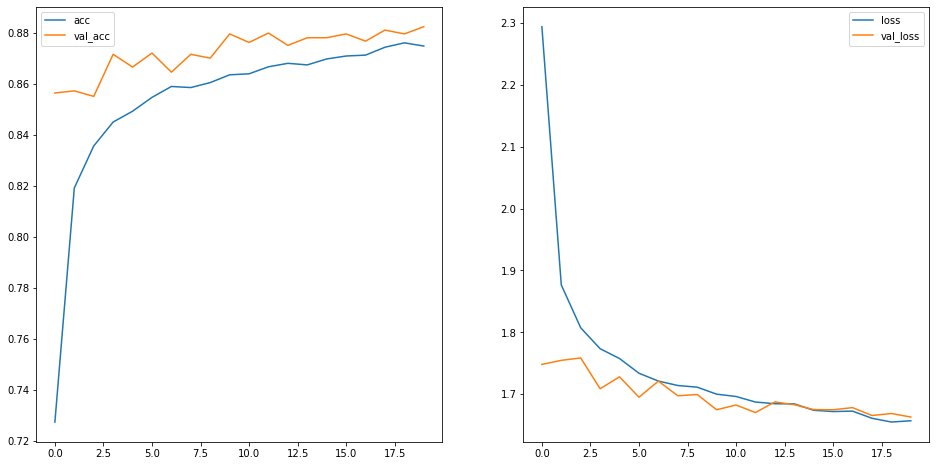

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['acc'],label='acc')
plt.plot(history.history['val_acc'],label='val_acc')
plt.legend()
plt.subplot(122)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [122]:
# predict用のmodel. ArcFaceLayerを除き,重みはloadして使用する
def create_predict_model(n_categories, file_path):
    arcface_model = create_mobilenet_with_arcface(n_categories, file_path) #学習と同じlayer数
    predict_model = Model(arcface_model.get_layer(index=0).input, arcface_model.get_layer(index=4).output) # MobileNetV2の出力までにして再構築
    predict_model.summary()

    return predict_model

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
    ...

In [19]:
predict_model = Model(arcface_model.get_layer(index=0).input, arcface_model.get_layer(index=5).output)
predict_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [20]:
batch_size = 32
feature_pred = predict_model.predict(x_test,batch_size=batch_size,verbose=1)

10000/10000 [==============================] - 1s 140us/step


In [21]:
from sklearn.preprocessing import normalize
# l2正規化
feature_pred_normalize = normalize(feature_pred,norm='l2')
#feature_pred_normalize = np.l2_normalize(feature_pred)

W0717 00:02:33.763906 4540978624 legend.py:1282] No handles with labels found to put in legend.


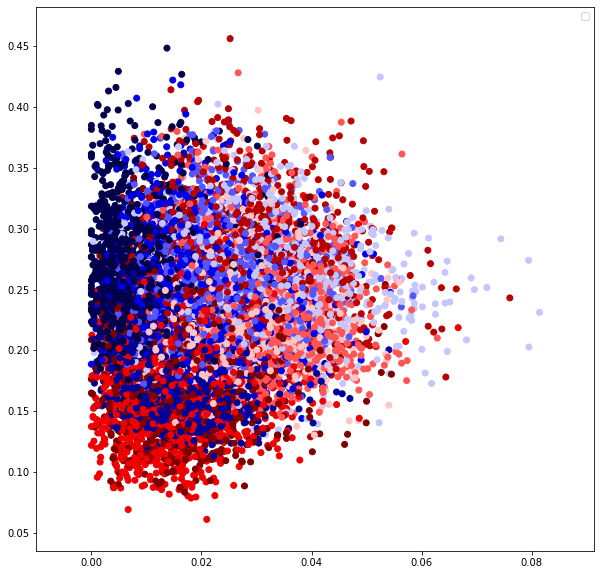

In [22]:
import matplotlib.cm as cm
# 可視化
y_test_label = np.argmax(y_test,axis=1)
plt.figure(figsize=(10,10))
plt.scatter(feature_pred_normalize[:,0],feature_pred_normalize[:,1],c=y_test_label,cmap=cm.seismic)
plt.legend()
plt.show()

In [23]:
base_vec = np.array([1 if i == 0 else 0 for i in range(feature_pred.shape[1])])
y_test_label = np.argmax(y_test,axis=1)
cosines = []
for i,feature in enumerate(feature_pred_normalize):
    cos = np.dot(base_vec,feature)
    y = y_test_label[i]
    cosines.append([y,cos])
    
hist = []
num_classes = 10
for i in range(num_classes):
    targets = [v[1] for v in cosines if v[0] == i]
    hist.append(targets)

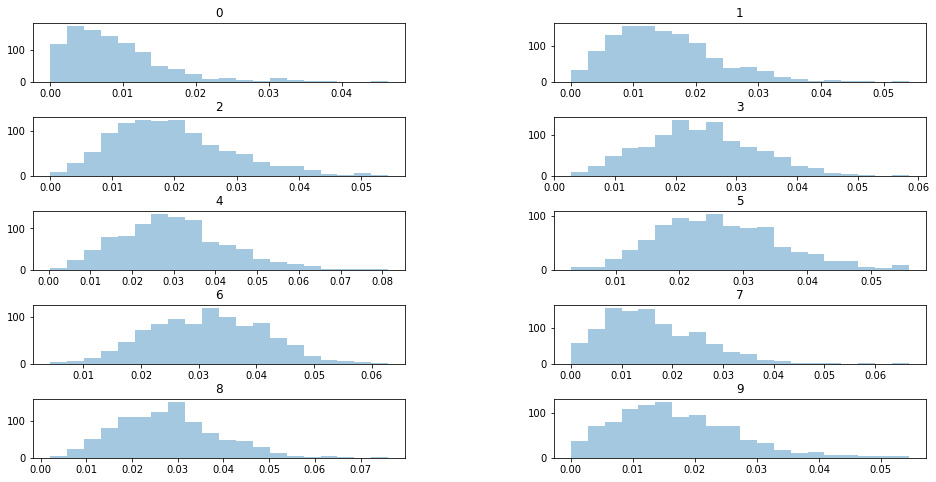

In [26]:
import seaborn as sns
rows = num_classes / 2
cols = 2
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(num_classes):
    plt.subplot(rows,cols,i+1)
    sns.distplot(hist[i], kde=False, rug=False, bins=20) 
    plt.title(i)
plt.show()

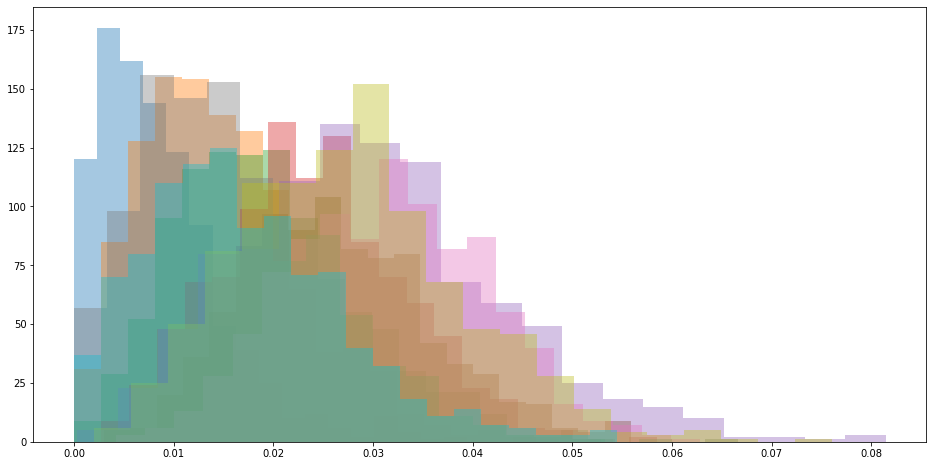

In [25]:
import seaborn as sns
rows = num_classes / 2
cols = 2
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(num_classes):
    #plt.subplot(rows,cols,i+1)
    sns.distplot(hist[i], kde=False, rug=False, bins=20) 
    #plt.title(i)
plt.show()

In [39]:
from sklearn.preprocessing import normalize
typical_vecs = arcface_model.get_layer(name='arc_face_2').get_weights()
typical_vecs_normalize = normalize(typical_vecs,norm='l2',)
num_classes = 10
resul = []
for i in range(num_classes):
    vec_i = typical_vecs_normalize[:,i]
    for j in range(num_classes):
        if i == j:
            continue
        vec_j = typical_vecs_normalize[:,j]
        resul.append(np.dot(vec_i,vec_j))

ValueError: Found array with dim 3. the normalize function expected <= 2.

In [38]:
weight[0].shape

(64, 10)